# Final Project for Personalization

## 0. Importing libs
we are using several common libs includes:
- pandas
- numpy 
- sklearn
- scipy

to deal with general data structure and also fastFM for fastorization machine.

In [3]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm_notebook
import collections
import time
import bisect
import matplotlib.pyplot as plt
import scipy
from fastFM import als
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from util import load_json, get_sum_count

In [4]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.types import IntegerType
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import time

## 1. Data Preprocessing
In this section we first decompress all the json file with self implemented function imported from util.py 
and then we filter out unactive user and split the dataset into train and test data. Also we generate
several auxiliry dataframe for group statistics for further usage.


### 1.1 Json Data Decompress 

In [3]:
for file_name in ['review','business','checkin','tip','user','photo']:
    load_json(file_name)

In [3]:
review_df = pd.read_csv('./yelp_dataset/review.csv')
review_df.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03


In [5]:
business_df = pd.read_csv('./yelp_dataset/business.csv')
business_df.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",NaN
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."


In [9]:
user_df = pd.read_csv('./yelp_dataset/user.csv')
user_df.head(3)

F:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,2013-10-08 23:11:33,84,17,25,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,...,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,NaN,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,...,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,David,16,2013-10-04 00:16:10,28,8,10,NaN,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,...,0,0,0,0,1,0,0,0,0,0


### 1.2 Unactive User Filter Out & Train/Test Split

#### 1.2.1 Unactive Filter

In [10]:
user_count = review_df['user_id'].value_counts()
user_count = pd.DataFrame(user_count)
user_count = user_count[user_count['user_id'] >= 5]
user_count = user_count.reset_index()
user_count.columns = ['user_id','count']

In [11]:
active_review_df = review_df.merge(user_count,on = 'user_id', how = 'inner')

In [12]:
print(str(len(user_count)*1.0/len(review_df['user_id'].value_counts())*100) + '% of user are active user')
print(str(len(active_review_df)*1.0/len(review_df)*100) + '% of reviews are rated by active user')

17.47745150378282% of user are active user
67.87825124515771% of reviews are rated by active user


As for here, we can see that only 17% users are active user and 17% user generated 67% reviews, which indicates a long-tail effect within the dataset.

#### Train/Test Split
To split the last comment and rating of each active user, we need to sort all user by the review time within each user group. Here we user dataframe groupby and apply function to extremely shorten the time consumption

In [13]:
sorted_group = active_review_df.sort_values('date').groupby('user_id')


start = time.time()
train_df = sorted_group.apply(lambda x:x[:-1])
print('finished in '+ str(time.time() - start) + ' sec.')


start = time.time()
test_df = sorted_group.apply(lambda x:x[-1:])
print('finished in '+ str(time.time() - start) + ' sec.')

finished in 1427.1481153964996 sec.
finished in 479.75861501693726 sec.


And we save train and test data for further usage

In [14]:
train_df = train_df.reset_index(drop = True)
train_df.to_csv('train.csv')
test_df = test_df.reset_index(drop = True)
test_df.to_csv('test.csv')

In [12]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### 1.3 Calculate Sum Dict
sum_dict is a dictionary that contain the rating information for each user
for each user_id as a key, the value is another dictionary contain the count of how many ratings scores are under (included) 2,3,4,5 and 6 reletively. This is used for calculating the rank accuracy for each test data point.
For instance, when we have a test sample with score of 4 and we predict it as 3, and suppose the user is user A
Then the rank of the original score is the sum of the scores rated by A under 4, and the rank of the predicted score is the sum of the scores rated by A under 3. Then we calculated the rank correlation to get the overall rank accuracy. See example below for the sum_dict

In [13]:
sum_dict = get_sum_count(train_df)

In [36]:
sum_dict["---1lKK3aKOuomHnwAkAow"]

[17, 22, 32, 55, 127]

As we can see above, for user "---1lKK3aKOuomHnwAkAow", he or she has 17 score 1, 5 score 2, 10 score 3, 23 score 4 and 72 score 5. So that within all his or her ratings, there are 17 reviews have a score under 2 and 22 reviews have a score under 3 and so on.
Thus, when we have a new predicted score come in, we can quickly give the rank of that prediction by reading the corresponding summation of the count of the reviews with specific score. And then accelerate the calculating of rank accuracy

## 2. Data Visualization
In this section, we explore the dataset and generate several figure about the data trying to show sme insight of the dataset.

### 2.1 Active Users

In [44]:
active_user_df = user_df.merge(user_count,on = 'user_id', how = 'inner')

In [45]:
active_user_df.describe()[['average_stars','review_count','useful']]

,average_stars,review_count,useful
count,286130.000000,286130.000000,286130.000000
mean,3.748822,60.538759,137.842348
std,0.706024,156.690863,1058.085528
min,1.000000,1.000000,0.000000
25%,3.380000,9.000000,5.000000
50%,3.830000,16.000000,14.000000
75%,4.220000,43.000000,45.000000
max,5.000000,13278.000000,154202.000000


As we can see here, the statistics of average stars, review count and useful are shown as above. In fact people tends to rating 3.74 which is higher than 3.0 as the average overall ratings. And in general for each user they may contribute 22 reviews and there are even a user contribute 13278 reviews(that's incredible actual, saying the user had been an active user for 10 years and contribute review everyday within last 10 years, he or she still need  to contribute aroun 3 to 4 reviews per day). And useful is another important statistic, for us to evaluate the importance of an user of a review. Most people have a 0 useful and a few have a high useful, it's like a social media.

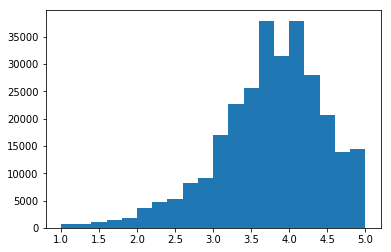

In [46]:
plt.hist(active_user_df['average_stars'],bins = 20)
plt.show()

Average stars seems like a right skewed normal distribution.

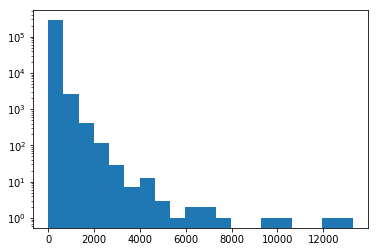

In [48]:
plt.hist(active_user_df['review_count'],bins = 20)
plt.yscale('log')
plt.show()b

To show this clearly, we change the scale for y axis as log-scale. Obviously, there is a long tail effect in this data

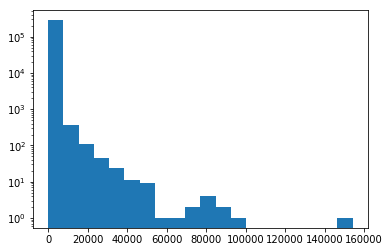

In [49]:
plt.hist(active_user_df['useful'],bins = 20)
plt.yscale('log')
plt.show()

similar to the review count, useful is long-tailed

## 2.2 Business

In [50]:
business_df.describe()

,is_open,latitude,longitude,review_count,stars
count,192609.000000,192609.000000,192609.000000,192609.000000,192609.000000
mean,0.823040,38.541803,-97.594785,33.538962,3.585627
std,0.381635,4.941964,16.697725,110.135224,1.018458
min,0.000000,33.204642,-115.493471,3.000000,1.000000
25%,1.000000,33.637408,-112.274677,4.000000,3.000000
50%,1.000000,36.144815,-111.759324,9.000000,3.500000
75%,1.000000,43.602989,-79.983614,25.000000,4.500000
max,1.000000,51.299943,-72.911982,8348.000000,5.000000


There are 82% business are still open, however, including the closed business may help us build better recommend system. 

## 2.3 Review

In [53]:
train_df.describe()

,cool,funny,stars,useful,count
count,4.252140e+06,4.252140e+06,4.252140e+06,4.252140e+06,4.252140e+06
mean,7.766306e-01,6.230369e-01,3.748399e+00,1.626710e+00,8.740699e+01
std,2.803070e+00,2.597718e+00,1.351254e+00,3.960639e+00,2.116509e+02
min,-1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,5.000000e+00
25%,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,1.100000e+01
50%,0.000000e+00,0.000000e+00,4.000000e+00,1.000000e+00,2.600000e+01
75%,1.000000e+00,0.000000e+00,5.000000e+00,2.000000e+00,7.900000e+01
max,2.900000e+02,9.700000e+02,5.000000e+00,1.241000e+03,4.129000e+03


Similar to the useful in active users, reviews have cool and funny attribute, but also seems long tail.

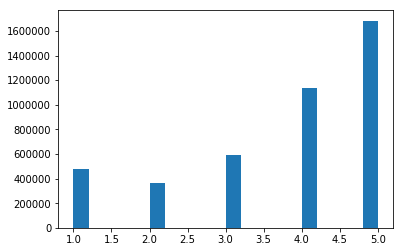

In [57]:
plt.hist(train_df['stars'],bins = 20)
plt.show()

Not same as average stars for each user, the stars distribution of reviews are not normal distribution, bu a more complicated one. People tends to rate more extreme score than average case. We can see rather than rate a 2, people tends to directly give a 1 instead or a 3.

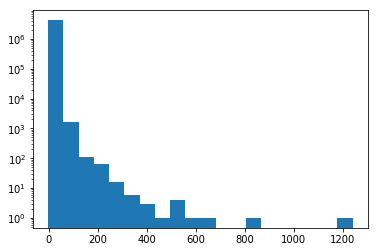

In [56]:
plt.hist(train_df['useful'],bins = 20)
plt.yscale('log')
plt.show()

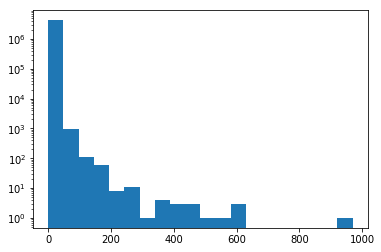

In [58]:
plt.hist(train_df['funny'],bins = 20)
plt.yscale('log')
plt.show()

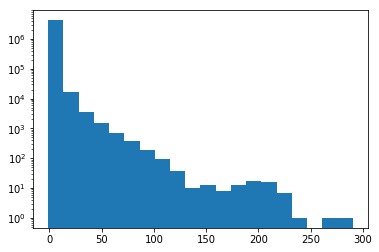

In [59]:
plt.hist(train_df['cool'],bins = 20)
plt.yscale('log')
plt.show()

Seems clicking cool attribute action is less concentrate rather than useful or funny.

## 3. Baseline

In this section, we will first discuss about the metrics we used to evaluate or recommend system and then talk about several baseline from random guess to a simple collaborative filtering and use the above metrics to have a sense of the difficulty of the problem.

### 3.1 Metrics
For the problem, we set up 3 method to evaluate our result. Mean Absolute Error, Mean Square Error, and Rank Accuracy. MAE and MSE are easy to understand and easy to implement. These two method evaluate the general error, from different perspective, MAE is the most geenral one and MSE punish more on larger difference.
Rank Accuracy, as we discussed a bit in section 1.3, we calculate the correlation score of the rank of true score for each test sample and the rank of predicted score for each test sample. As absolute score may not mean the same for different user, however, rank may be more meaningful.

In [27]:
def mae(true, pred):
    '''
    true: as a vector
    pred: as a vector
    calculating mean absolute error
    '''
    assert len(true) == len(pred)
    return np.mean(np.abs(true - pred))


def mse(true, pred):
    '''
    true as a vector
    pred as a vector
    calculating mean square error
    '''
    assert len(true) == len(pred)
    return np.mean(np.abs(true - pred) * np.abs(true - pred))


def get_rank(sum_dict, arraylike):
    score = arraylike['stars']
    user = arraylike['user_id']
    return sum_dict[user][min(max(1,int(score + 0.5)),5) - 1]


def get_rank_pred(sum_dict, arraylike):
    score = arraylike['prediction']
    user = arraylike['user_id']
    return sum_dict[user][min(max(1,int(score + 0.5)),5) - 1]


def rank_accuracy(sum_dict, prediction):
    '''
    input prediction dataframe and make user_id as index
    '''
    rank_true = prediction.apply(lambda x: get_rank(sum_dict, x), axis=1)
    rank_pred = prediction.apply(lambda x: get_rank_pred(sum_dict, x), axis=1)
    return np.corrcoef(rank_true, rank_pred)[0][1]


In [15]:
def get_metrics(sum_dict,pred_df):
    return (mae(pred_df['stars'],pred_df['prediction']),
            mse(pred_df['stars'],pred_df['prediction']),
            rank_accuracy(sum_dict,pred_df))

Code is shown above and also could be found in metrics.py

### 3.2 Random Guess
We first apply a random guess regressor to have a sense of lower bound of the problem.

In [16]:
y_pred = np.random.choice([1,2,3,4,5],size = [len(test_df)])
pred_df = test_df.copy()
pred_df['prediction'] = y_pred

In [84]:
mae_score,mse_score,rank_accuracy_score = get_metrics(sum_dict,pred_df)
result = pd.DataFrame(columns = ['mae_score','mse_score','rank_accuracy_score'])
result.loc['random_guess'] = [mae_score,mse_score,rank_accuracy_score]
result

,mae_score,mse_score,rank_accuracy_score
random_guess,1.782483,4.916178,0.666511


### 3.3 Baseline - Matrix Factorization

Then, we tried to trian a matrix factorization model as our baseline model only using user_id, business_id and stars.

Since we will use ALS in spark, which requires user_id and business_id to be numerical, we first transform user_id and business_id to user_index and business_index

In [4]:
train = train_df[['user_id','business_id','stars','date']]
test = test_df[['user_id','business_id','stars','date']]

In [5]:
n = train_df.shape[0]
m = test_df.shape[0]
train_user_id = train_df['user_id'].unique()
train_business_id = train_df['business_id'].unique()
user_id_index = {}
business_id_index = {}
for i in range(len(train_user_id)):
    user_id_index[train_user_id[i]] = i
for i in range(len(train_business_id)):
    business_id_index[train_business_id[i]] = i
    
nu = len(user_id_index)
nb = len(business_id_index)
test_user_id = test_df['user_id'].unique()
test_business_id = test_df['business_id'].unique()
for i in range(len(test_user_id)):
    if test_user_id[i] not in user_id_index:
        user_id_index[test_user_id[i]] = nu
        nu += 1
for i in range(len(test_business_id)):
    if test_business_id[i] not in business_id_index:
        business_id_index[test_business_id[i]] = nb
        nb += 1

In [8]:
train['user_index'] = train.user_id.map(user_id_index)
train['business_index'] = train.business_id.map(business_id_index)
test['user_index'] = test.user_id.map(user_id_index)
test['business_index'] = test.business_id.map(business_id_index)

train = train[['user_index','business_index','stars','date','user_id','business_id']]
test = test[['user_index','business_index','stars','date','user_id','business_id']]

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

In [9]:
train.to_csv('spark_train.csv', index=False, header=False)
test.to_csv('spark_test.csv', index=False, header=False)

In [8]:
sc = SparkContext('local')
spark = SparkSession(sc)

spark_train = spark.read.csv("spark_train.csv")
spark_test = spark.read.csv('spark_test.csv')

spark_train = spark_train.withColumnRenamed('_c0', 'user_index')
spark_train = spark_train.withColumnRenamed('_c1', 'business_index')
spark_train = spark_train.withColumnRenamed('_c2', 'rating')
spark_train = spark_train.withColumnRenamed('_c3', 'date')
spark_train = spark_train.withColumnRenamed('_c4', 'user_id')
spark_train = spark_train.withColumnRenamed('_c5', 'business_id')
spark_train = spark_train.withColumn("user_index", spark_train["user_index"].cast(IntegerType()))
spark_train = spark_train.withColumn("business_index", spark_train["business_index"].cast(IntegerType()))
spark_train = spark_train.withColumn("rating", spark_train["rating"].cast('float'))
spark_train.show()

+----------+--------------+------+-------------------+--------------------+--------------------+
|user_index|business_index|rating|               date|             user_id|         business_id|
+----------+--------------+------+-------------------+--------------------+--------------------+
|         0|             0|   4.0|2008-11-11 04:31:46|---1lKK3aKOuomHnw...|5cbsjFtrntUAeUx51...|
|         0|             1|   4.0|2008-11-11 04:40:05|---1lKK3aKOuomHnw...|--9e1ONYQuAa-CB_R...|
|         0|             2|   5.0|2009-01-16 21:49:36|---1lKK3aKOuomHnw...|ifEHr-ZnGFSKgJVsy...|
|         0|             3|   4.0|2010-10-16 23:27:02|---1lKK3aKOuomHnw...|kosTPb88O4Q0XGbVb...|
|         0|             4|   5.0|2010-10-16 23:31:28|---1lKK3aKOuomHnw...|rq5dgoksPHkJwJNQK...|
|         0|             5|   1.0|2010-10-17 04:19:01|---1lKK3aKOuomHnw...|2BbFeotL85cIaBjSq...|
|         0|             6|   1.0|2010-11-05 20:08:08|---1lKK3aKOuomHnw...|78TC3sZSYBzBsSJ0z...|
|         0|             7|   

In [9]:
spark_test = spark_test.withColumnRenamed('_c0', 'user_index')
spark_test = spark_test.withColumnRenamed('_c1', 'business_index')
spark_test = spark_test.withColumnRenamed('_c2', 'rating')
spark_test = spark_test.withColumnRenamed('_c3', 'date')
spark_test = spark_test.withColumnRenamed('_c4', 'user_id')
spark_test = spark_test.withColumnRenamed('_c5', 'business_id')
spark_test = spark_test.withColumn("user_index", spark_test["user_index"].cast(IntegerType()))
spark_test = spark_test.withColumn("business_index", spark_test["business_index"].cast(IntegerType()))
spark_test = spark_test.withColumn("rating", spark_test["rating"].cast('float'))
spark_test.show()

+----------+--------------+------+-------------------+--------------------+--------------------+
|user_index|business_index|rating|               date|             user_id|         business_id|
+----------+--------------+------+-------------------+--------------------+--------------------+
|         0|           121|   5.0|2018-10-11 23:29:57|---1lKK3aKOuomHnw...|Hqs4YNST_ZHbshwyi...|
|         1|         73463|   2.0|2014-04-21 16:58:28|--0kuuLmuYBe3Rmu0...|PYe_FDw6QTbTf66Wc...|
|         2|         29288|   5.0|2018-10-04 02:02:28|--2HUmLkcNHZp0xw6...|KW9RNyBPmc77f9FsO...|
|         3|          3746|   3.0|2018-01-11 04:24:17|--2vR0DIsmQ6WfcSz...|BLIJ-p5wYuAhw6Pp6...|
|         4|         15598|   4.0|2018-09-03 19:32:11|--3WaS23LcIXtxyFU...|UKrfUw8quQiQM2N9i...|
|         5|         12851|   5.0|2018-05-15 19:54:15|--44NNdtngXMzsxyN...|YNf4Yi9l7wa1U8k5K...|
|         6|          2272|   3.0|2012-06-17 16:59:06|--4q8EyqThydQm-eK...|rcaPajgKOJC2vo_l3...|
|         7|         22441|   

In [10]:
als_5 = ALS(maxIter=5, rank = 5, userCol="user_index", itemCol="business_index", ratingCol="rating",
          coldStartStrategy="drop")

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

model_5 = als_5.fit(spark_train)

In [20]:
predictions_5 = model_5.transform(spark_test)
spark_prediction = predictions_5.toPandas()
spark_prediction.rename(columns={"rating": "stars"}, inplace=True)

In [29]:
mae_score,mse_score,rank_accuracy_score = get_metrics(sum_dict,spark_prediction)
result = pd.DataFrame(columns = ['mae_score','mse_score','rank_accuracy_score'])
result.loc['MF(Baseline)'] = [mae_score,mse_score,rank_accuracy_score]
result

,mae_score,mse_score,rank_accuracy_score
MF(Baseline),1.3412,3.192332,0.821464


After implementing MF, we can see that all these three metrics increase a lot. However, we only use user_id, business_id as our features when we trained this baseline model. In the next section, we will try more features and a new model.

## 4 Feature Engineer
In this section, we deal with part of the original features and convert them into union form. Feature engineering includes modification of following features:

- Average stars, useful, cool and funny of the user
- Count of friends of the user
- Embedded vector of business feature
 - Summation of review text vector
 - Categorical vector
 - Name vector
- Feature vector of user

### 4.1 user part

In [134]:
y_train = train_df['stars']
x_train = train_df[['user_id','business_id','text']]
y_test = test_df['stars']
x_test = test_df[['user_id','business_id','text']]

In [130]:
user_df['friends_count'] = user_df['friends'].apply(lambda x:len(x.split(',')) if x else 0)
for col in ['cool','fans','funny','useful']:
    user_df['average_' + col] = user_df[col] / user_df['review_count']

In [135]:
x_train = x_train.merge(user_df[['user_id','average_stars','average_cool','average_fans','average_funny','average_useful','friends_count']],
                       on = 'user_id',how= 'inner')
x_test = x_test.merge(user_df[['user_id','average_stars','average_cool','average_fans','average_funny','average_useful','friends_count']],
                       on = 'user_id',how= 'inner')

### 4.2 business part

In [200]:
x_train['text'].fillna("",inplace = True)

In [ ]:
start = time.time()
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_vec.fit(x_train['text'])
print(time.time() - start)

In [ ]:
start = time.time()
text_tfidf = tfidf_vec.transform(x_train['text'])
x_train['text_tfidf'] = [text_tfidf[i] for i in tqdm_notebook(range(len(train_df)))]
print(time.time() - start)

In [ ]:
start = time.time()
text_tfidf = tfidf_vec.transform(x_test['text'])
x_test['text_tfidf'] = [text_tfidf[i] for i in tqdm_notebook(range(len(test_df)))]
print(time.time() - start)

In [ ]:
x_train[:1000][['business_id','text_tfidf']].groupby('business_id').apply(lambda x:x['text_tfidf'].sum())

## 5 Factorization Machine
In this section, we utilize factorization machine as a method to include side information of user and business. We join the features and one-hotted index together to run the FM based on fastFM. 